In [1]:
import sys
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# from scipy.interpolate import UnivariateSpline
# from scipy import stats
import pickle

from itertools import chain
from scipy.optimize import curve_fit

# Import ART

sys.path.append('.')
sys.path.append('../ART_iGEM')

from art.core import *
import art.plot as plot

# setting the colorscheme of the figures
COLOR = '#307890'
mpl.rcParams.update({'text.color' : COLOR,
                     'axes.labelcolor' : COLOR,
                     'xtick.color': COLOR,
                     'ytick.color': COLOR, 
                     'axes.edgecolor': COLOR})

Do not have mpi4py package.
Do not have acor package


# Step 1: Loading the data

The Automated Recommendation tool is used to determine which combination of *Saccharomyces spp.* strain, promotor, secretion peptide and alpha-amylase gene is expected to yield a high alpha-amylase activity. The training data for ART consists of alpha-amylase activity produced by 53 samples out of the possible 640 combinations. This activity was measured using the Alpha-amylase Assay kit. See the explanaition of the results on our [wiki page](https://2021.igem.org/team:Groningen/Results).



However, the first step is to load in the various data files and make sure they have the correct data type

In [2]:
samples = pd.read_csv('Filled_sample_list.csv', sep=',')

# filtering out the non-existant measurments:

print(len(samples))

samples = samples.loc[samples['Activity']!='_']
samples['Corrected activity'] = samples['Corrected activity'].astype('float64')
samples.info()


192
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 188
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Line Name           159 non-null    object 
 1   Replicate           159 non-null    object 
 2   Activity            159 non-null    object 
 3   str_idx             159 non-null    int64  
 4   pro_idx             159 non-null    int64  
 5   sec_idx             159 non-null    int64  
 6   gen_idx             159 non-null    int64  
 7   Corrected activity  159 non-null    float64
 8   prediction_x        141 non-null    float64
 9   cv_prediction_x     141 non-null    float64
 10  prediction_y        141 non-null    float64
 11  cv_prediction_y     141 non-null    float64
 12  prediction          141 non-null    float64
 13  cv_prediction       141 non-null    float64
dtypes: float64(7), int64(4), object(3)
memory usage: 18.6+ KB


The info box above should show that the `Line Name` and `Replicate` columns have the Dtype `object`, the has the Dtype `float64` and all other columns have the Dtype `int64`

## Step 2: Restructuring the data

The ART needs a unique name for each replicate. Therefore, the `Line Name` and `Replicate` are combined into a single `Line Name`. Furthermore, ART is designed for the optimization of a genetically engineered machine in which the expression of several protein is varied. Under these circumstances, proteomic and transcriptomic data is generally used as the input data (Radivojević, Costello & Workman et al., 2020). In our case however, the main interest lies within optimizing the activity of a single enzyme. As our focus is on the activity and not the abundance of the enzyme, proteomic data on the absolute protein content of the micro organism is not a representative performance measure. Furthermore, transcriptomic data of the gene with encodes for alpha-amylase is not the only variable which can influence the activity of alpha-amylase. The strain in which the enzyme is produced, the secretion peptide of the protein and the variant of alpha-amylase also influence activity of the resulting enzyme. Therefore, a different measurement type is needed as input data.
Zhang, Petersen & Radivojević et al. (2020) faced a similar problem. They varied the promoters of 5 different genes in order to optimize tryptophan digestion in Saccharomyces cerevisiae. However, transcriptomic data of each gene was not available. What they did instead, was looking at which promoter combination yielded the best tryptophan digestion. Each promoter was given a unique index. By one-hot-encoding each of these indexes, the promoter combinations can be expressed in a sparse binary vector. This sparse vector can be used instead of the more common transcriptomic data. A similar approach was chosen for our project. Instead of looking at different promoters, other parts of the genetically engineered machine are optimized. Each of the part-variants is given a unique index which in turn can be translated to a one-hot-encoded vector.

Most of the code you see below is either taken directly from the publication of Zhang, Petersen & Radivojević et al. (2020), or it is heavily inspired by it.

#### References:
Radivojević, T., Costello, Z., Workman, K. et al. A machine learning Automated Recommendation Tool for synthetic biology. Nat Commun 11, 4879 (2020). https://doi.org/10.1038/s41467-020-18008-

Zhang, J., Petersen, S.D., Radivojević, T. et al. Combining mechanistic and machine learning models for predictive engineering and optimization of tryptophan metabolism. Nat Commun 11, 4880 (2020). https://doi.org/10.1038/s41467-020-17910-1

In [3]:
samples["Line Name"] = samples["Line Name"] + "-" + samples["Replicate"]

samples = samples.loc[:,['Line Name','Corrected activity','str_idx', 'pro_idx', 'sec_idx', 'gen_idx']]

In [4]:
samples_art_oneh = pd.get_dummies(data=samples, columns=['str_idx', 'pro_idx', 'sec_idx', 'gen_idx'])
samples_art_oneh.head()

,Line Name,Corrected activity,str_idx_1,str_idx_2,str_idx_3,str_idx_4,pro_idx_5,pro_idx_6,pro_idx_7,pro_idx_8,...,pro_idx_13,pro_idx_14,sec_idx_15,sec_idx_16,sec_idx_17,sec_idx_18,gen_idx_19,gen_idx_20,gen_idx_21,gen_idx_22
0,#01-r0,-5.216721,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,#01-r1,-5.208366,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,#01-r2,-5.197097,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,#02-r0,-10.095819,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,#02-r1,-10.213089,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


After the transformation, the columns in the dataframe represent the line name of the machine, the corrected activity measure of this line and which part-variants were used in constructing this line. 

In [5]:
# store the columnnames as parameter setting for ART
colnames = samples_art_oneh.columns[2:].tolist()
print(colnames)

['str_idx_1', 'str_idx_2', 'str_idx_3', 'str_idx_4', 'pro_idx_5', 'pro_idx_6', 'pro_idx_7', 'pro_idx_8', 'pro_idx_9', 'pro_idx_10', 'pro_idx_11', 'pro_idx_12', 'pro_idx_13', 'pro_idx_14', 'sec_idx_15', 'sec_idx_16', 'sec_idx_17', 'sec_idx_18', 'gen_idx_19', 'gen_idx_20', 'gen_idx_21', 'gen_idx_22']


The input data is fed to the ART measurement by measurement. This makes it impossible to feed the entire one-hot encoded vector to the ART at once. The trick is to consider each entry in the one-hot-encoded vector as a 'measurement' on wether the line contains this part-variant. A `1.000000` in the `Value` column would indicate that the part-variant listed in the `Measurement Type` column is preset in the line listed in the `Line Name` column. A `0.000000` would indicate the oposite. 

In [6]:
# Pivot the dataframe and change the column names
samples_art_oneh = samples_art_oneh.set_index('Line Name').stack().reset_index()
samples_art_oneh.columns = ['Line Name', 'Measurement Type', 'Value']
print(samples_art_oneh)
samples_art_oneh.to_csv('test.csv')

     Line Name    Measurement Type     Value
0       #01-r0  Corrected activity -5.216721
1       #01-r0           str_idx_1  0.000000
2       #01-r0           str_idx_2  1.000000
3       #01-r0           str_idx_3  0.000000
4       #01-r0           str_idx_4  0.000000
...        ...                 ...       ...
3652    #63-r2          sec_idx_18  0.000000
3653    #63-r2          gen_idx_19  0.000000
3654    #63-r2          gen_idx_20  0.000000
3655    #63-r2          gen_idx_21  1.000000
3656    #63-r2          gen_idx_22  0.000000

[3657 rows x 3 columns]


## Step 3: Outlier detection

Measurements can be noisy and sometimes it is impossible to determine whether the results of a sample can be attributed to the functioning of the sample, of if the results are due to some random measuring error. This is the reason that each measurement was taken in triplicates. In theory, each replicate of the same sample should give a somewhat similar activity measurement. In practice, there is often one replicate that shows a substantially different activity compared to the other two measurements. The ART has an intergrated tool which can be used for exluding the samples in which the variance within the replicates of the same sample is greater than the variance within `x`% of all samples. This `x` needs to be guessed depending on the accuracy of the measurements.

In [7]:
measurement = ['Corrected activity']

In [8]:
cut_off_perc = 90
noisy_line_name = utils.find_noisy_data(samples_art_oneh, measurement, percentile=cut_off_perc,plot_flag=False)
samples_art_oneh_filtered = utils.filter_noisy_data(samples_art_oneh, noisy_line_name, measurement, filter_all_replicates=True,plot_flag=False)


../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


,Value,Measurement Type,Replicate Mean,Replicate Error
Line Name,,,,
#06-r0,-11.512925,Corrected activity,-10.200589,-1.312337
#06-r1,-7.575915,Corrected activity,-10.200589,2.624674
#06-r2,-11.512925,Corrected activity,-10.200589,-1.312337
#11-r0,-11.512925,Corrected activity,-10.109325,-1.403600
#11-r1,-7.302125,Corrected activity,-10.109325,2.807200
#11-r2,-11.512925,Corrected activity,-10.109325,-1.403600
#20-r0,-11.512925,Corrected activity,-9.130414,-2.382512
#20-r1,-4.365390,Corrected activity,-9.130414,4.765023
#20-r2,-11.512925,Corrected activity,-9.130414,-2.382512


,Line Name,Measurement Type,Value
207,#06-r0,Corrected activity,-11.512925
230,#06-r1,Corrected activity,-7.575915
253,#06-r2,Corrected activity,-11.512925
483,#11-r0,Corrected activity,-11.512925
506,#11-r1,Corrected activity,-7.302125
529,#11-r2,Corrected activity,-11.512925
1035,#20-r0,Corrected activity,-11.512925
1058,#20-r1,Corrected activity,-4.365390
1081,#20-r2,Corrected activity,-11.512925
1794,#32-r0,Corrected activity,-11.411683


In [9]:
errors = utils.add_replicate_mean_and_error(samples_art_oneh, ['Corrected activity'])['Replicate Error']
limit = round(np.percentile(abs(errors), cut_off_perc),10)
print("The value that delimites the {} percent most extreme errors is: {}".format((100-cut_off_perc),limit))

../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


The value that delimites the 10 percent most extreme errors is: 0.6118861878


In [10]:
errors.abs().mean()*2.5

0.723964061398342

In order to determine wether the excluded samples were indeed outliers, the differences between mean of a sample and the actual activity measurement of the replicates of that sample are plotted below. It should be noticable that most of the differences are centered around `0`. Samples in which the absolute difference is substantially more than the expected `0` should be considered to be excluded from the analysis.

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


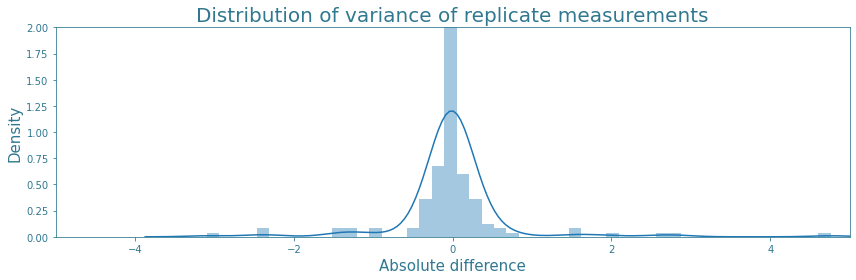

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax);
ax.set_ylim(0, 2)
ax.set_xlim(-5, 5)
ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Absolute difference', fontsize=15)
plt.title('Distribution of variance of replicate measurements', fontsize=20)
fig.savefig('./figures/Error.pdf', transparent=True)
fig.savefig('./figures/Error.png', transparent=True)

The red lines drawn in the figure bolow indicate at which point a sample is considered an outlier according to the ART.

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


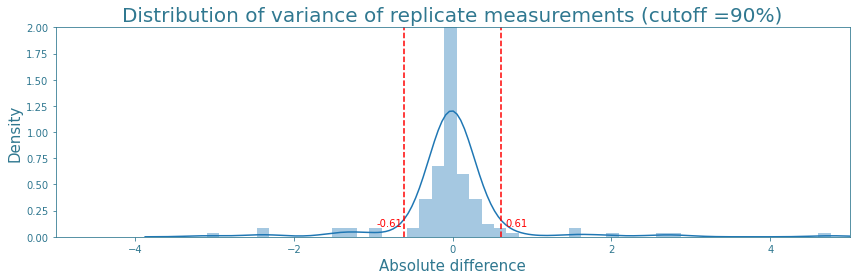

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax)
ax.set_ylim(0, 2)
ax.set_xlim(-5, 5)
ax.axvline(x=limit, ymin=0, color='r', ls='--')
ax.axvline(x=-limit, ymin=0, color='r', ls='--')
ax.annotate(str(round(-limit, 2)), xy=(-limit, 0), xytext=(-limit-0.35, 0.1), color='r')
ax.annotate(str(round(limit, 2)), xy=(limit, 0), xytext=(limit+0.05, 0.1), color='r')
ax.set_xlabel('Absolute difference', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
plt.title(str('Distribution of variance of replicate measurements (cutoff ='+str(cut_off_perc)+'%)'), fontsize=20)
fig.savefig('./figures/Excluded.pdf', transparent=True)
fig.savefig('./figures/Excluded.png', transparent=True)

## Step 4: RUNNING ART!!!!!

Now that the data is correctly structured and the outlier have been removed, it is time to run the ART. First, the following ART paramaters need to be defined

In [13]:
art_params = {}
art_params['response_vars'] = measurement
art_params['input_vars'] = colnames
art_params['seed'] = 42  # default: None
art_params['num_recommendations'] = 30   
art_params['cross_val'] = True
art_params['recommend'] = False
art_params['output_directory'] = 'results_onehot/'


Training the ART takes some time. Fortunatly, this only needs to be done once. If there is already a trained ART model, it is not needed to run it again.

In [14]:
run_art = False

In [15]:
%%time
if run_art:
    art = RecommendationEngine(samples_art_oneh_filtered, **art_params)
else:
    with open('results_onehot/art.pkl', 'rb') as output:
        art = pickle.load(output)

CPU times: user 1.61 s, sys: 95.2 ms, total: 1.71 s
Wall time: 2.78 s


## Step 5: Starting with analysis of the data

After having trained the ART, it is time to interpret the results from the ART. The ultimate goal is to find out how acturate the predictions made by the ART will be on samples which have not been tested. Unfortunatly, this is impossible as it is unknown what exact activity of the untested samples will be. The best we can do, is give an approximation.

A powerfull tool for this approximation is *k-fold cross-validation*. The idea is to split the entire dataset into `k` (almost) equally sized *folds*. Afterwards, the model is trained `k` times, where each time one of the folds is excluded from the training data. Once training is done, the model is validated on the fold that was excluded from the training data. This gives an approximation of what would happen if the model would encounter new samples. The error between the predictions and the actual measurements can be used to determine the Mean Absolute Error (MAE), Mean Relative Absolute Error (MRAE), standard deviation of the Absolute Error (stdAE), Mean Squared Error (MSE) and $R^2$ value of the model. The most important parametric to look at is the $R^2$ value as it represents how well the model is able to explain the validation data. An $R^2$-value of $1.0$ means that the model is able to explain 100% of the data. A value of $0.0$ or less means non of the data can be explained by the model. 

This process of *k-fold cross-validation* can be repeated for all the models used to construct the final `Ensamble Model`. The ensamble model should yield (one of) the highest $R^2$-values.

In [16]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,1.869930,19.530151,1.293938,5.170913,-0.482436
Random Forest Regressor,0.990339,11.091182,0.818945,1.651443,0.526552
TPOT Regressor,0.869675,10.121001,0.748215,1.316160,0.622674
Support Vector Regressor,1.187564,13.686708,0.732745,1.947223,0.441756
Kernel Ridge Regressor,5.470537,54.886046,2.563921,36.500463,-9.464223
K-NN Regressor,1.631781,18.460882,1.033223,3.730261,-0.069419
Gaussian Process Regressor,1.111148,12.605081,0.756142,1.806399,0.482128
Gradient Boosting Regressor,1.093072,11.850803,0.871696,1.954661,0.439623
Ensemble Model,0.898801,10.098613,0.688716,1.282173,0.632417


The $R^2$-value is a good first indication on how will the model is able to explain the data. However, further analysis is needed in order to check if there are unexpected patterns in the predictions (e.g. an outlier). A correlation plot can be used for this purpose. A correlation plot between the observerd and the predicted measurement should yield a straight diagonal line if the model is able to make perfect predictions (i.e. the observed measurement = predicted measurment). 

The plot below shows the crossvalidated ensemble prediction compared to observations of mean productivity of library and control strains (i.e. the unused folds during the k-fold cross-validation)


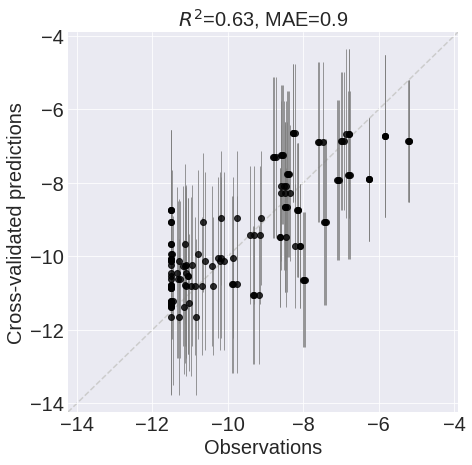

In [17]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=True, log=False)

Chances are the plot above is does not show a nice diagonal line. This could have a range of different causes. To only list a few:

1. The measuring error is too big
2. The pattern generating the activity values is too complex to learn based on the current set of training samples
3. The model is undertrained
4. The model is over trained

At his point, not much can be done about the first two points. Reducing the measuring error is likely to require a complete re-design of the experiment. The second problem could possibly be mitigated with attitional training samples, although there is no guarantee that this would work. Point three can be checked relatively easily by checking the non-cross-validated corralation plot. If the non-cross-validated model is able to accurately reproduce the its training data, the model is likely to have learned enough to prevent underfitting. This corralation graph is shown in the cell below

Check wether the model is over trained (point 4), most often requires a deeper analysis of the learning curves of the models. Unfortunatly, we did not manage to get the script written by Zhang, Petersen & Radivojević et al. (2020) for creating the learning curves to work due to a lack of time. 

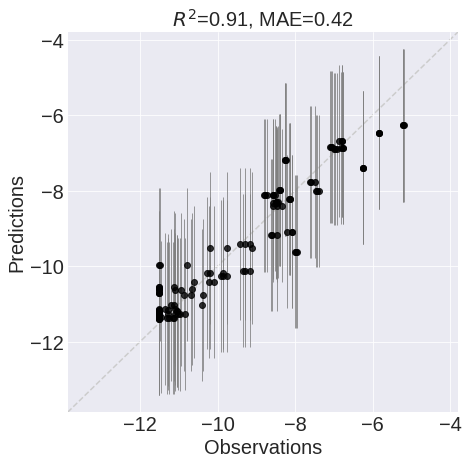

In [18]:
plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=True, log=False)

The corralation plot shown above is simply the pretiction of the tool plotted agains the actual measurement. In order to get more insights on which parts showed a larger discriptancy between measurement and prediction, we added to predictions of the ART to the original sample list.

In [19]:
cv_prediction = np.array(art.model_df_cv[0]['Predictions']['Ensemble Model'])
print(len(cv_prediction))
print(len(samples_art_oneh_filtered['Line Name'].unique()))
predicted_mean, predicted_std = art.post_pred_stats(art.load_input_data(scale=False))

library_pred_df = pd.DataFrame({'Line Name' : samples_art_oneh_filtered['Line Name'].unique(),'prediction' : predicted_mean.squeeze(), 'cv_prediction' : cv_prediction})
library_pred_df['Line Name'], library_pred_df['Replicate'] = library_pred_df['Line Name'].str.split('-', 1).str
print(library_pred_df)

141
141
    Line Name  prediction  cv_prediction Replicate
0         #01   -6.273726      -6.862900        r0
1         #01   -6.273726      -6.862900        r1
2         #01   -6.273726      -6.862900        r2
3         #02  -10.411779     -10.123156        r0
4         #02  -10.411779     -10.123156        r1
..        ...         ...            ...       ...
136       #62  -11.187616     -10.532690        r1
137       #62  -11.187616     -10.532690        r2
138       #63   -8.004694      -9.068543        r0
139       #63   -8.004694      -9.068543        r1
140       #63   -8.004694      -9.068543        r2

[141 rows x 4 columns]


/tmp/ipykernel_8552/2200241233.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  library_pred_df['Line Name'], library_pred_df['Replicate'] = library_pred_df['Line Name'].str.split('-', 1).str


Now, combine the predictions dataframe with the measured data

In [20]:

print(library_pred_df.head())
samples = pd.read_csv('Sample_list.csv', sep=',')
print(samples.head())

samples = pd.merge(samples, library_pred_df,  how='left', left_on=['Line Name', 'Replicate'], right_on = ['Line Name', 'Replicate'])
samples.head()
samples.to_csv('Sample_list.csv', sep=',', index=False)

  Line Name  prediction  cv_prediction Replicate
0       #01   -6.273726      -6.862900        r0
1       #01   -6.273726      -6.862900        r1
2       #01   -6.273726      -6.862900        r2
3       #02  -10.411779     -10.123156        r0
4       #02  -10.411779     -10.123156        r1
  Line Name Replicate                Activity  str_idx  pro_idx  sec_idx  \
0       #01        r0   0.0054250887901738645        2        6       16   
1       #01        r1    0.005470604462374471        2        6       16   
2       #01        r2    0.005532602321888791        2        6       16   
3       #02        r0  4.1251653161869854e-05        4       11       18   
4       #02        r1    3.66869783376127e-05        4       11       18   

   gen_idx  Corrected activity  prediction_x  cv_prediction_x  prediction_y  \
0       22           -5.216721     -6.273726        -6.862900     -6.273726   
1       22           -5.208366     -6.273726        -6.862900     -6.273726   
2       22  

/tmp/ipykernel_8552/2215215547.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cv_prediction_x', 'prediction_x'} in the result is deprecated and will raise a MergeError in a future version.
  samples = pd.merge(samples, library_pred_df,  how='left', left_on=['Line Name', 'Replicate'], right_on = ['Line Name', 'Replicate'])


At this point, it should be clear wether the results from the ART are generalisable to new samples. If there are any doubts, it is highly unlikely that the ART will be able to make accurate predictions. The tool might still be usefull for identifying trends in which combinations are likely to good results, but the predicted activity of those combinations are to be taken with a grain of salt.

## Step 6: Using the ART for making predicitons

Now that the ART is all trained and well, it finally possible to use the tool for making predictions on un-tested samples. First, again a list of all the possible designs (i.e. the combinatorial library) needs to be generated.

In [21]:
num_strains = 4
num_promoters = 10
num_secretion_signals = 4
num_genes = 4

num_designs = num_strains*num_promoters*num_secretion_signals*num_genes
num_promoters_onehot = art.num_input_var

designs = np.zeros((num_designs, num_promoters_onehot))

i = 0

strains = np.eye(num_strains)
promoters = np.eye(num_promoters)
secretion = np.eye(num_secretion_signals)
genes = np.eye(num_genes)

for p1 in strains:
    for p2 in promoters:
        for p3 in secretion:
            for p4 in genes:
                designs[i,:] = np.hstack((p1,p2,p3,p4)).astype(int)
                i+=1

print(designs[:5])


[[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]]


Calculate mean predicted production and standard deviation for all possible designs.

In [22]:
pp_mean, pp_std = art.post_pred_stats(designs)

The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [23]:
art.rel_eng_accuracy = 0.01

Finally, we also need to load in the names of the parts associated with the indeces

In [24]:
part_names = pd.read_csv('part_names.csv')
part_names = part_names.set_index('Index')

list(part_names.Name[[1,5,10,22]])

['ySB76', 'pTDH3', 'pPAB1', 'B.subtilis']

### Exploitative approach

The objective function for the ART is defined as the mean predicted production. This will therefore yield a list of combinations that are most likely to yield a good activity

In [39]:
obj_func = pp_mean 
data = np.hstack((designs, obj_func, obj_func))
print(data)

[[  1.           0.           0.         ...   0.          -9.23657459
   -9.23657459]
 [  1.           0.           0.         ...   0.         -10.75844517
  -10.75844517]
 [  1.           0.           0.         ...   0.          -8.63317944
   -8.63317944]
 ...
 [  0.           0.           0.         ...   0.         -11.12598145
  -11.12598145]
 [  0.           0.           0.         ...   0.         -10.67992615
  -10.67992615]
 [  0.           0.           0.         ...   1.          -8.03127013
   -8.03127013]]


In [40]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

../ART_iGEM/art/core.py:1610: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])
../ART_iGEM/art/core.py:1610: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])


Mean and standard deviation of the recommendation with the highest predicted production are: -6.24, 1.03


In [41]:
df_rec_categ_exploit = pd.DataFrame(index=art.recommendations.index, columns=['strain','promoter','secretion','gene',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][np.round(art.recommendations.values[i,:]).astype('int64') != 0]
    strain, promoter, secretion, gene = [int(float(p.split('_')[2])) for p in rec.index[:-1]]
    df_rec_categ_exploit.iloc[i][('strain','promoter','secretion','gene')] = list(part_names.Name[[strain, promoter, secretion, gene]])
    df_rec_categ_exploit.iloc[i][measurement] = rec[measurement]

df_rec_categ_exploit['Predicted activity'] = np.exp(np.array(df_rec_categ_exploit[measurement].values.tolist()))

df_rec_categ_exploit

,strain,promoter,secretion,gene,Corrected activity,Predicted activity
0,ySB78,pPGK1,αMF,B.subtilis,-6.241298,0.001947
1,ySB78,pTDH3,αMF,B.subtilis,-6.323765,0.001793
2,ySB76,pRNR2,αMF,B.subtilis,-6.363736,0.001723
3,ySB85,pPGK1,αMF,B.subtilis,-6.388392,0.001681
4,ySB76,pPGK1,αMF,B.subtilis,-6.435489,0.001604
5,ySB77,pRNR2,αMF,B.subtilis,-6.521911,0.001471
6,ySB77,pTDH3,αMF,B.subtilis,-6.566358,0.001407
7,ySB76,pHHF1,αMF,B.subtilis,-6.573551,0.001397
8,ySB76,pRNR1,αMF,B.subtilis,-6.666158,0.001273
9,ySB76,pTDH3,αMF,B.subtilis,-6.676021,0.001261


In [ ]:
df_rec_categ_exploit.nunique()

### Explorative approach

The objective function for the ART is defined as the variance of the predicted production. Therefore, this setting will produce a list with combination for which the ART is most uncertain. Testing these combinations and adding the results to the training data will therefore greatly enhance the predictive capabilities of the ART.

In [34]:
obj_func = pp_std 
data = np.hstack((designs, obj_func, obj_func))


In [35]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendations with the highest variance in the prediction are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

../ART_iGEM/art/core.py:1610: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])
../ART_iGEM/art/core.py:1610: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])


Mean and standard deviation of the recommendations with the highest variance in the prediction are: -6.32, 1.06


In [36]:
df_rec_categ_explor = pd.DataFrame(index=art.recommendations.index, columns=['strain','promoter','secretion','gene',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][np.round(art.recommendations.values[i,:]).astype('int64') != 0]
    strain, promoter, secretion, gene = [int(float(p.split('_')[2])) for p in rec.index[:-1]]
    df_rec_categ_explor.iloc[i][('strain','promoter','secretion','gene')] = list(part_names.Name[[strain, promoter, secretion, gene]])
    df_rec_categ_explor.iloc[i][measurement] = rec[measurement]

df_rec_categ_explor['Predicted activity'] = np.exp(np.array(df_rec_categ_explor[measurement].values.tolist()))

df_rec_categ_explor

,strain,promoter,seqretion,gene,Corrected activity,Predicted activity
0,ySB78,pTDH3,αMF,B.amyloliquefaciens,-10.158696,0.000039
1,ySB78,pTDH3,Native,B.amyloliquefaciens,-10.167739,0.000038
2,ySB78,pRPL18B,αMF_no_EAEA,A.oryzae,-9.694006,0.000062
3,ySB78,pPAB1,αMF_no_EAEA,B.licheniformis,-9.807968,0.000055
4,ySB78,pTDH3,αMF,B.subtilis,-6.323765,0.001793
5,ySB78,pPGK1,αMF,B.amyloliquefaciens,-10.157919,0.000039
6,ySB78,pTDH3,Native,B.subtilis,-7.246373,0.000713
7,ySB78,pRNR1,αMF_no_EAEA,B.amyloliquefaciens,-10.167606,0.000038
8,ySB78,pRNR1,αMF_no_EAEA,A.oryzae,-9.742028,0.000059
9,ySB78,pHHF1,αMF_no_EAEA,B.amyloliquefaciens,-10.261079,0.000035


In [ ]:
df_rec_categ_explor.nunique()